In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [2]:
# Path dataset pada Windows
base_path = r'C:\Users\LENOVO\Documents\Bangkit\Capstone\DermMel' 
train_dir = os.path.join(base_path, "train_sep")
valid_dir = os.path.join(base_path, "valid")
test_dir = os.path.join(base_path, "test")


In [ ]:
img_size = (224, 224)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# Preprocessing and Augmentation
def preprocess(image, label):
    image = tf.image.resize(image, img_size)
    image = image / 255.0  # Rescale to [0, 1]
    return image, label

def prepare_dataset(data_dir, augment=False):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="binary"
    )
    if augment:
        dataset = dataset.map(lambda x, y: (tf.image.random_flip_left_right(x), y))
    return dataset.map(preprocess).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

train_data = prepare_dataset(train_dir, augment=True)
valid_data = prepare_dataset(valid_dir)
test_data = prepare_dataset(test_dir)

Found 10682 files belonging to 2 classes.
Found 3562 files belonging to 2 classes.
Found 3561 files belonging to 2 classes.


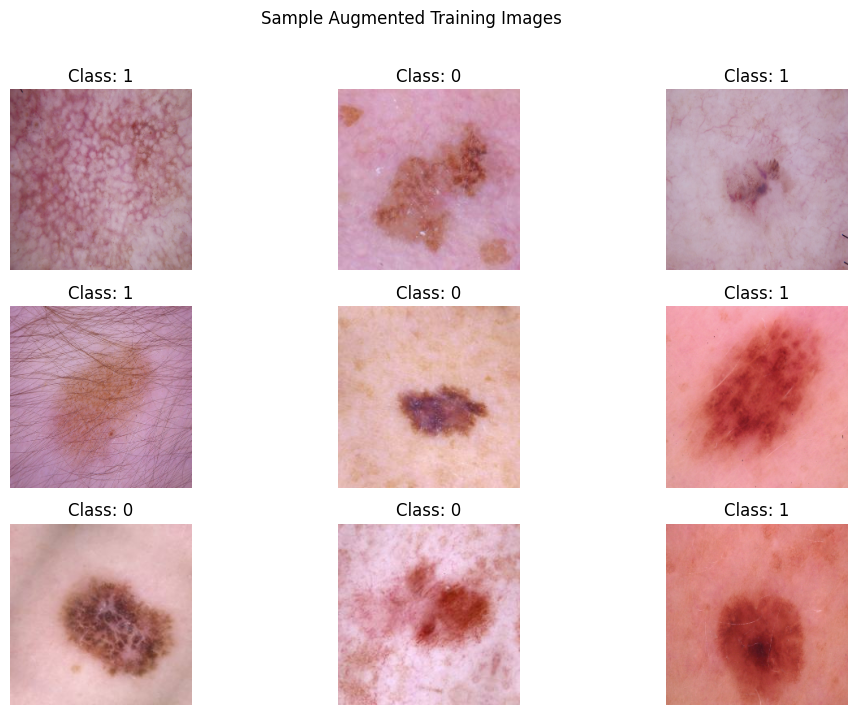

In [4]:
# Plot example images
def plot_sample_images(dataset, title):
    images, labels = next(iter(dataset))
    plt.figure(figsize=(12, 8))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Class: {int(labels[i].numpy())}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_sample_images(train_data, "Sample Augmented Training Images ")

In [5]:
# Define the Model
base_model = MobileNetV2(input_shape=img_size + (3,), include_top=False, weights='imagenet')
base_model.trainable = True  # Enable fine-tuning

# Unfreeze the last few layers of MobileNetV2
for layer in base_model.layers[:-4]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 414081 (1.58 MB)
Non-trainable params: 1845184 (7.04 MB)
_________________________________________________________________


In [6]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [7]:
# Train the Model (without class_weight)
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=20,
    callbacks=[early_stopping ]
)

Epoch 1/20


334/334 [==============================] - 159s 469ms/step - loss: 0.4103 - accuracy: 0.8260 - auc: 0.9000 - val_loss: 0.2716 - val_accuracy: 0.9163 - val_auc: 0.9581
Epoch 2/20
334/334 [==============================] - 149s 445ms/step - loss: 0.2591 - accuracy: 0.9083 - auc: 0.9571 - val_loss: 0.2266 - val_accuracy: 0.9200 - val_auc: 0.9664
Epoch 3/20
334/334 [==============================] - 145s 434ms/step - loss: 0.2239 - accuracy: 0.9188 - auc: 0.9657 - val_loss: 0.2070 - val_accuracy: 0.9211 - val_auc: 0.9703
Epoch 4/20
334/334 [==============================] - 145s 433ms/step - loss: 0.2072 - accuracy: 0.9238 - auc: 0.9693 - val_loss: 0.1948 - val_accuracy: 0.9245 - val_auc: 0.9729
Epoch 5/20
334/334 [==============================] - 144s 432ms/step - loss: 0.1938 - accuracy: 0.9267 - auc: 0.9731 - val_loss: 0.1846 - val_accuracy: 0.9290 - val_auc: 0.9746
Epoch 6/20
334/334 [==============================] - 144s 432ms/step - loss: 0.1876 - accuracy: 0.9300 - au

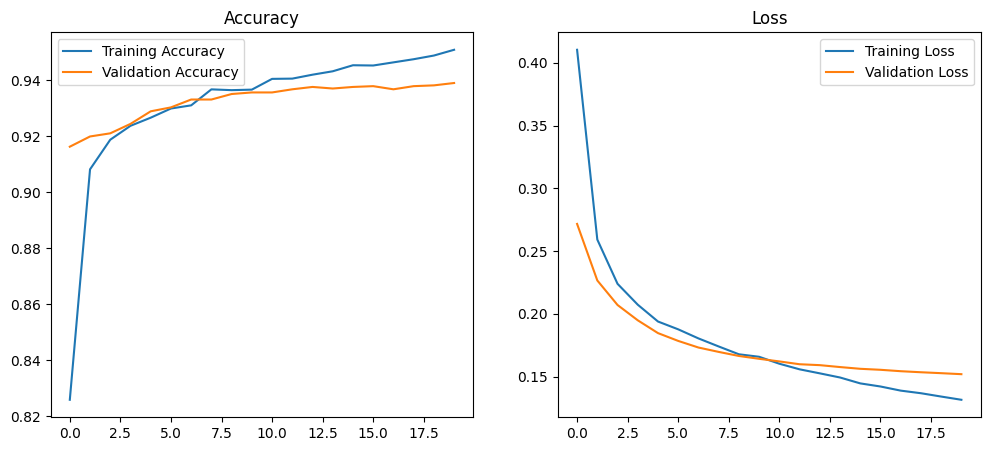

In [8]:
# Plot Training History
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

plot_training_history(history)

In [11]:
# Evaluate the Model
# Evaluate the Model
test_loss, test_accuracy, test_auc = model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test AUC: {test_auc:.4f}")



112/112 [==============================] - 35s 313ms/step - loss: 0.1683 - accuracy: 0.9326 - auc: 0.9779
Test Loss: 0.1683
Test Accuracy: 93.26%
Test AUC: 0.9779


In [12]:
# Save the Model Architecture and Weights
model_structure = model.to_json()
with open(os.path.join(base_path, "melanoma_detector_model.json"), "w") as json_file:
    json_file.write(model_structure)

model.save_weights(os.path.join(base_path, "melanoma_detector_weights.bin"))
print("Model architecture saved to JSON and weights saved to BIN successfully!")


Model architecture saved to JSON and weights saved to BIN successfully!


In [14]:
# Save the Model
model.save(os.path.join(base_path, "melanoma_detector_finetuned_full.h5"))
print("Fine-tuned Model on Full Dataset saved successfully in the local directory!")

Fine-tuned Model on Full Dataset saved successfully in the local directory!


c:\Users\LENOVO\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
